Canopy Systems

Real Tray Level Irrigation Data: Trend Analysis

Rev 1

Case Study 1

# Introduction:



**Why Irrigation?**

In indoor agriculture, managing irrigation correctly is a critical task. The goal is to closely simulate the plant's natural rhythms throughout the year. Mimicking seasonal cycles as close as possible helps with flowering, seed production, offshoots, and overall yield.



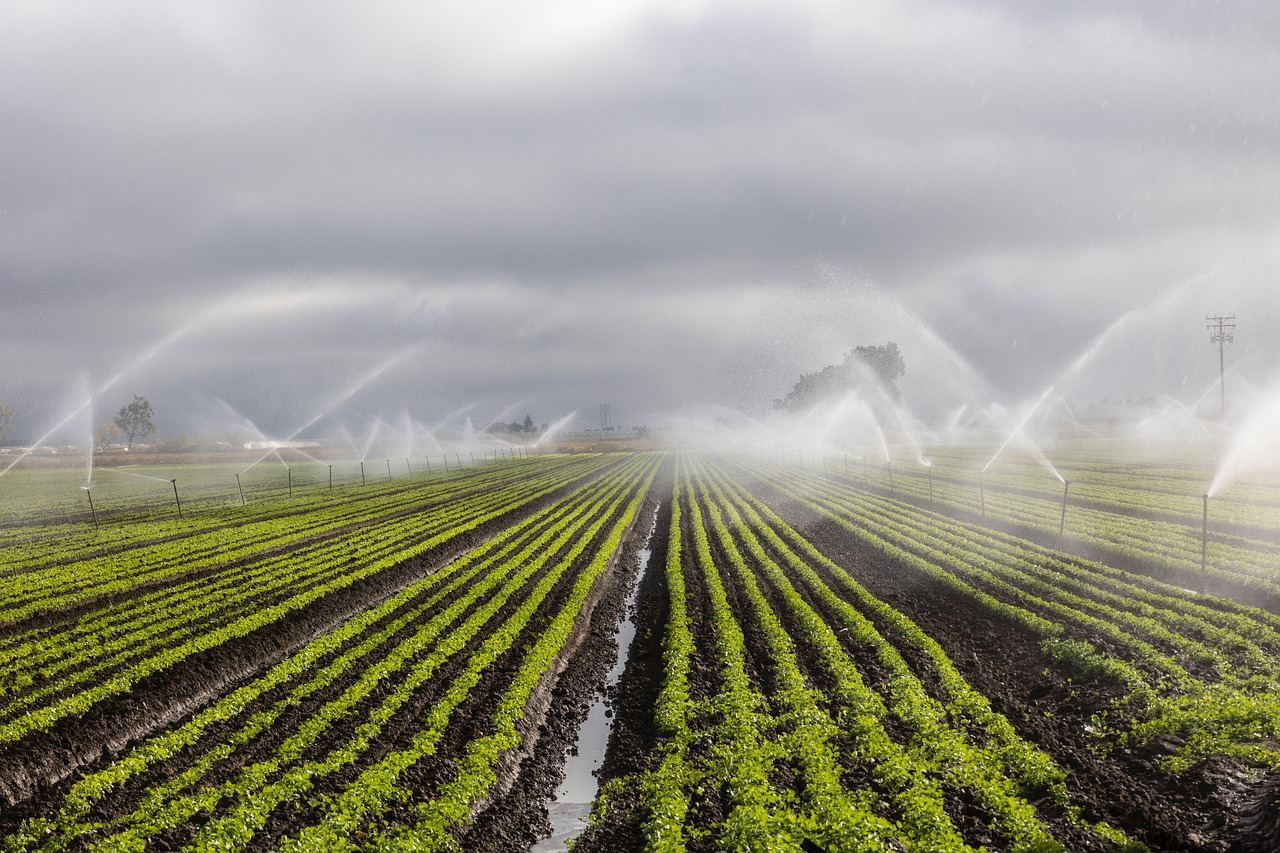

**Real World Example**

In drier climates such as coastal Australia, the water table recedes dramatically during the harsh summers, triggering many annuals to seed and die off, and perennials to form tubers, which begin shooting up stolons during the wet and mild Australian winters when insects and pollinators are abundant.

Maintaining artificial irrigation cycles long term is an arduous process to do by hand. How can we use past data to figure out the right water levels for the future?



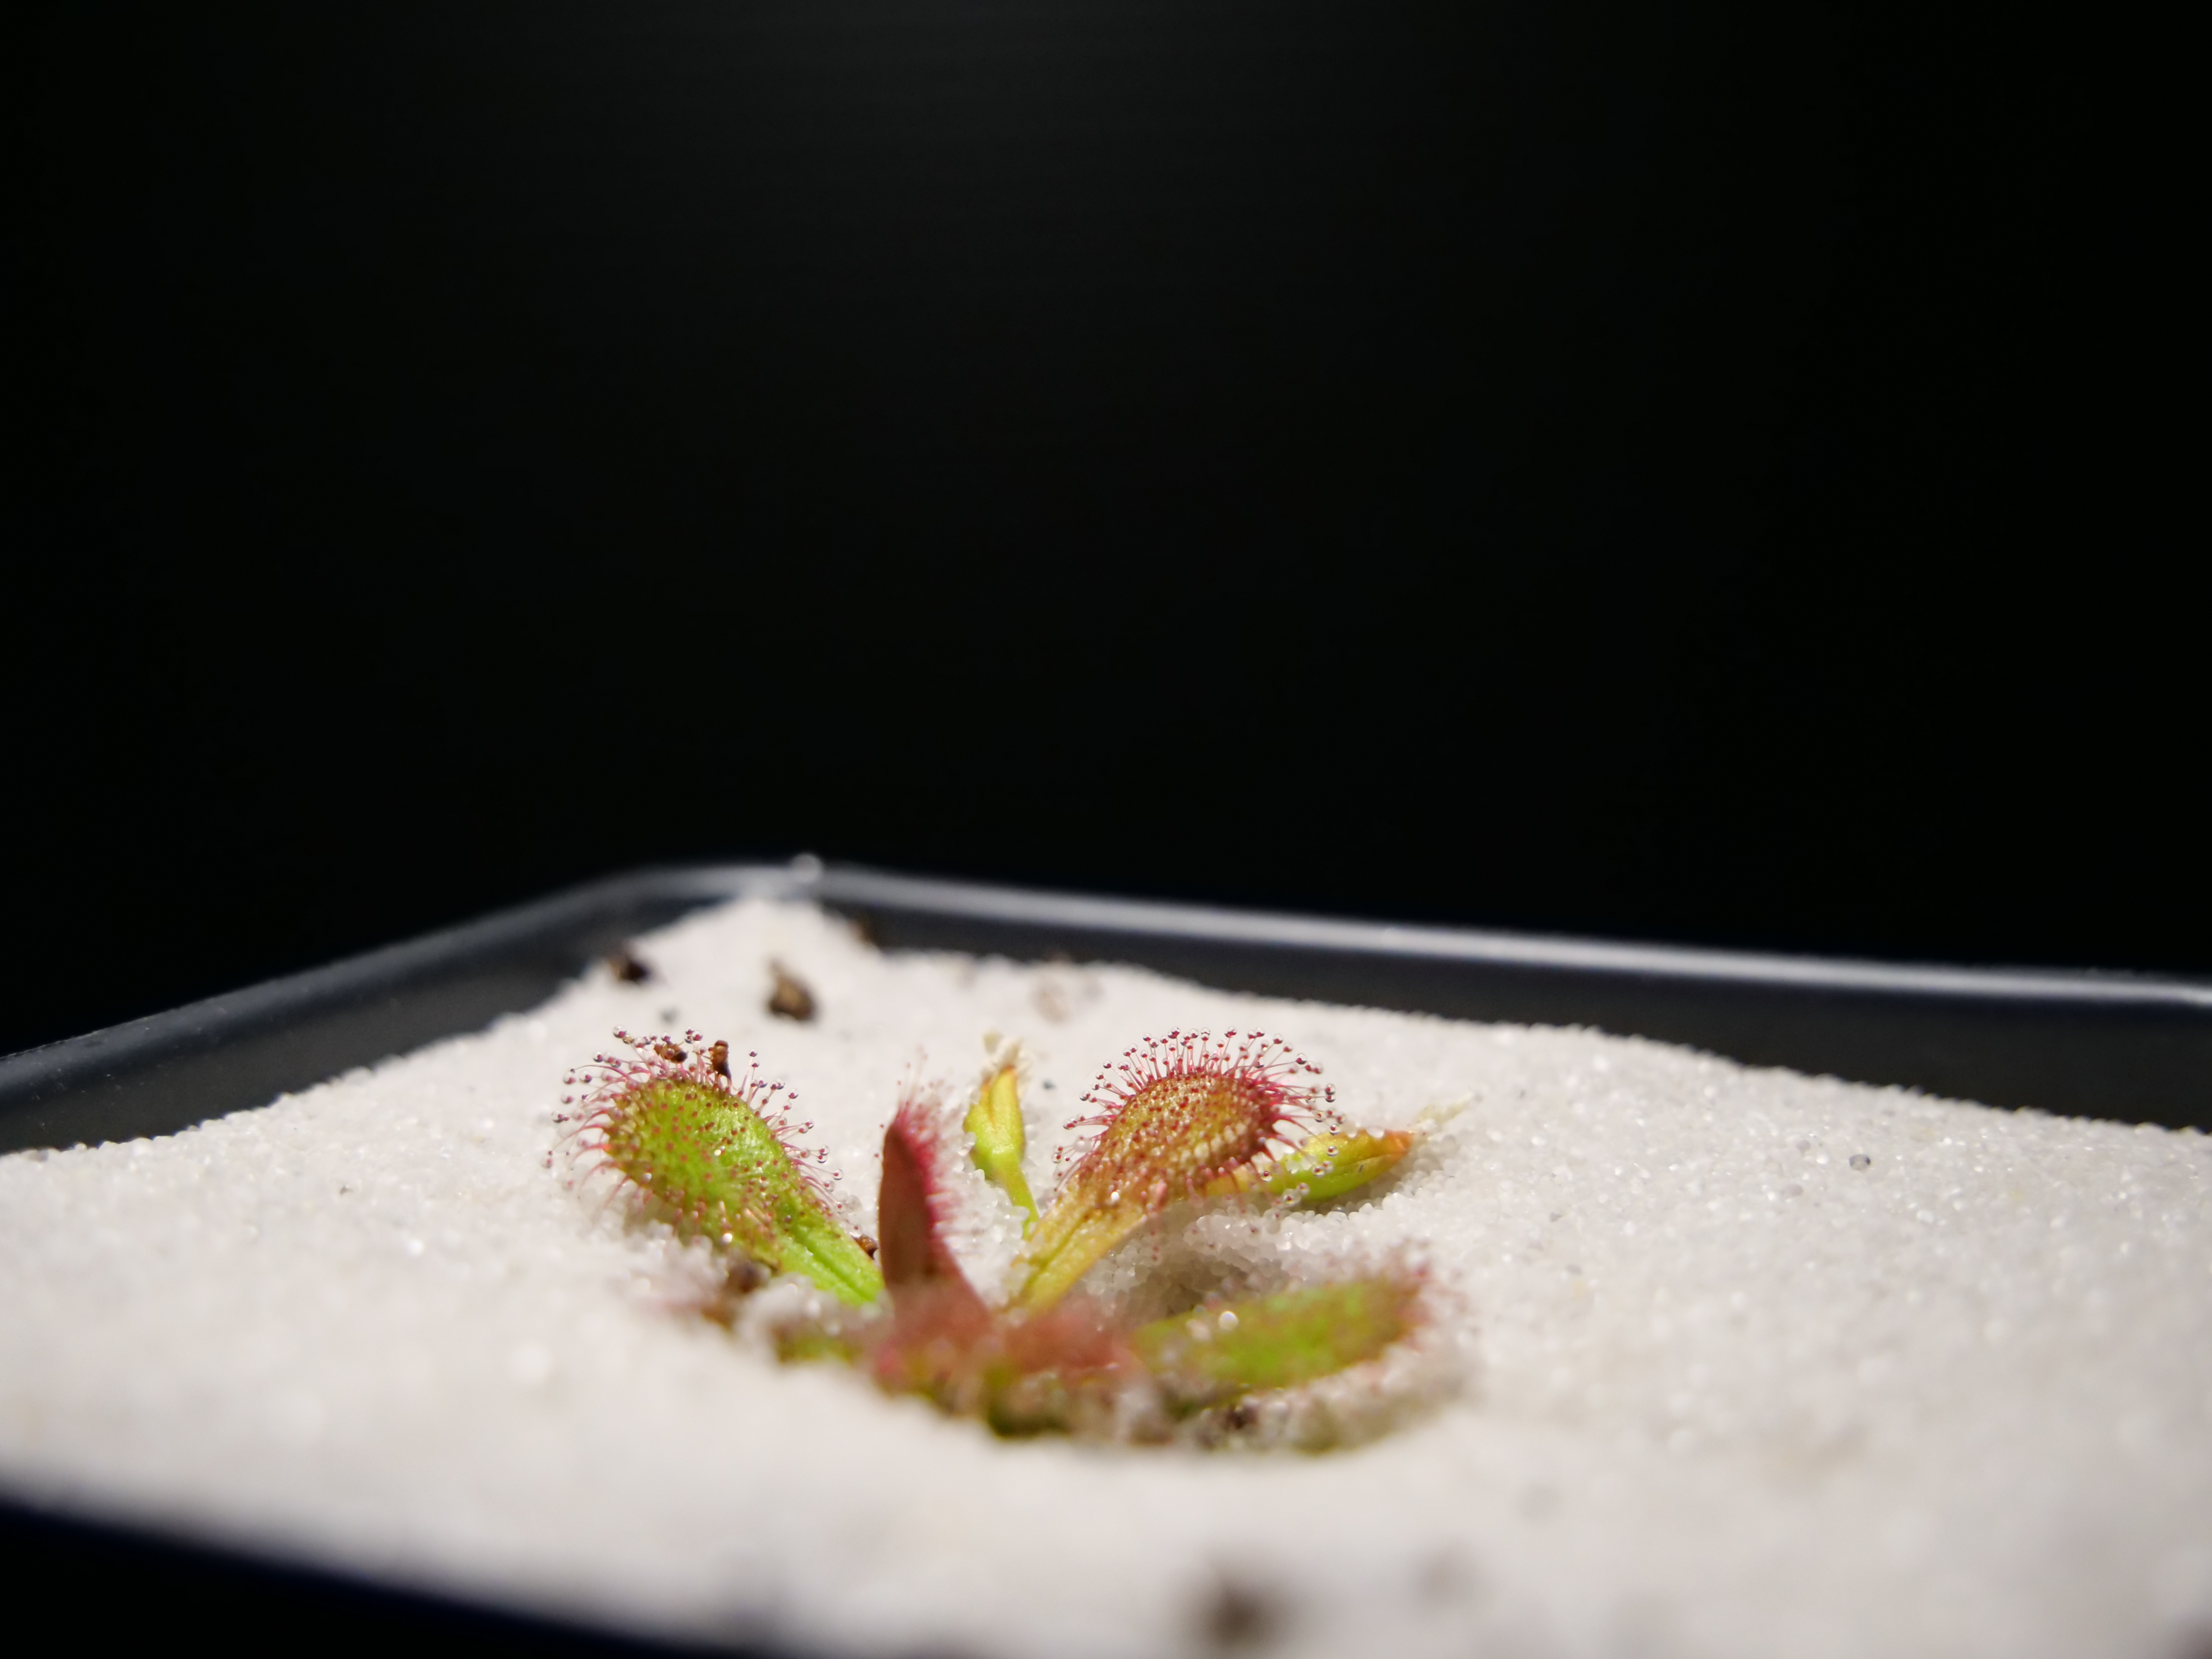

Above: Drosera Aberrans, Maldon Vic - a rosetted carnivorous flowering plant that uniquely cycles between an underground tuber in the harsh summer sand beds of Australian wilderness, and a carnivorous phase during the wetter winters. Monitoring irrigation levels is extremely important for such plants, where even a slight change in water during the summers can quickly kill the sensitive tuber.

# The Case Study


In this short case study, we will be exploring an indoor water level dataset for a tray of coastal Australian sundew species that go through steep water changes throughout the season. This is just the first revision, as this is real data and not necessarily perfect, so I'm learning along with this as well.

This dataset features water level, humidity, temperature, and sensor battery levels from July - Nov 2024, for multiple sensors! You can use this dataset to build models on your own after this case study if you wish. Feel free to share what you come up with!

Currently, the data is sampled by a level sensor attached to the tray and connected to a wireless Canopy sensor unit.

In [ ]:
INSERT LEVEL SENSOR PICTURE HERE!

# Motivation

We want to figure out if there's any trends in the data that we can use for a new alert system, which will eventually connect directly to a small irrigation tank (coming soon).

Further down the road, we'll train a ML model on additional data to begin managing watering levels based on the plant you specify!




# Short Code Tutorial: Processing the Sensor Dataset

To access the dataset, give Colab permissions to access files on your drive by running the following.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Let's import a couple modules we'll be using. Pandas is a popular Python data science library for both statistics and data analysis. Meanwhile, Numpy helps us work with and manipulate 1D and 2D data arrays.

We'll also import matplotlib to plot the data later.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

Let's pull the relevant data columns we're working with from the CSV (comma separated values) file! You can open this file in an editor to see the full list of columns.

The sensor box is capable of measuring water level, humidity, temperature, air pressure, and battery. You can pull these out individually and take a look at the data later.

Specify the file path where you dropped the CSV file in Google Drive.

In [ ]:
file_path = '/content/drive/MyDrive/data_files/ESP_data_backup11_21_2024.csv'

We'll use Pandas to read the CSV file from our path, and do some basic data cleaning. The **dropna** function drops any rows with empty or NaN (Not a Number) values. The sensor might rarely publish empty rows due to noise, weak connection, or low battery.

In [ ]:
#use pandas to read CSV file from specified path.
data = pd.read_csv(file_path)

#drop any rows with ALL NaN values
#this gets rid of the rows after valid entries, making the data easier to work with.
data_cleaned = data.dropna(how='all')

Let's now pull a couple of columns from the updated cleaned dataset! You can access individual columns by referencing their header name in the dataset.

In [ ]:
#storing all of the data:
moist_level = data_cleaned['moist1']
humidity = data_cleaned['humidity']
temperatureC = data_cleaned['temp']
temperatureF = (data_cleaned['temp'])
pressure = data_cleaned['pressure']
tags = data_cleaned['tag']
timestampStr = data_cleaned['timestamp']

Each Canopy device has a unique assigned identity address. This isn't the real "MAC" address, but rather a mask on top of the real device's address that's used to reference it in the app. Whenever the device publishes data, it reports its self-designated identity.

For the Australian sundew tray, the identity address is stored below in mac_address starting with "BR:..."


We only want to examine the rows with this address in the file. We'll then extract the water level column stored in 'moist1', and ensure the data is a number rather than a string.

We'll then use numpy to squeeze the two 1D arrays (x values) and water level (y values) together to form an array of (x,y) data points, where x is a time ticker (1 hour increments) and y is the water level.

In [ ]:
#Filter the data by MAC address:
mac_address = 'BR:08:M5:PI:13:OI:4Z:MR'
column = 'moist1'
filtered_data = data_cleaned[data_cleaned['tag'] == mac_address]

#Extract water level:
y = pd.to_numeric(filtered_data[column], errors='coerce').dropna().values

#Create the x array (sequential indices starting from 1)
x = np.arange(1, len(y) + 1)

#stacks 2 1D columns to form a 2D (x,y) column.
xy = np.column_stack((x,y))

print("Generated (x,y) data:")
print(xy)

Generated (x,y) data:
[[   1  833]
 [   2  828]
 [   3  826]
 ...
 [2952 1552]
 [2953 1569]
 [2954 1554]]


Note: the water level data above has no meaning on its own. They are simply voltage measurements on an interval between 0-4096. When the sensor turns on and samples some data, the current level of the water gets translated from an analog voltage signal to a digital value via the device's builtin analog to digital converter (ADC). Since the ADC is a 12-bit converter on Canopy Devices, the translated voltage reading can range between 0 to 2^12 - 1, or 0 to 4096.

If you wish, you can convert this value to a percentage by using some basic statistics. We'll leave that up to you. The advantage is potentially less variable data.

# Plotting the Irrigation Dataset for Australian Tray

Let's finally plot our curated data using matplotlib!

We'll set our canvas size, specify a scatter plot using our x and y arrays, and also superimpose a line plot to get an idea of any trends at a glance.

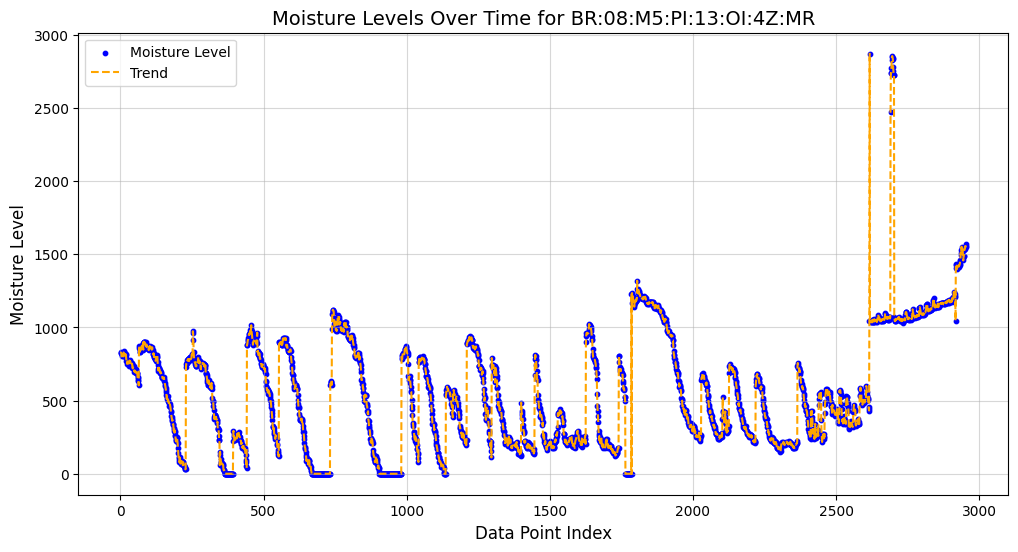

In [ ]:
plt.figure(figsize=(12, 6))
#s = 10, size of scatter point markers
plt.scatter(x,y, color='blue', s=10, label='Moisture Level')

#Line plot to connect points for trend visualization
plt.plot(x,y, color='orange', linestyle='--', label='Trend')

plt.xlabel('Data Point Index', fontsize=12)
plt.ylabel('Moisture Level', fontsize=12)
plt.title(f'Moisture Levels Over Time for {mac_address}', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)  # Add a faint grid for readability

# Show the plot
plt.show()

Interesting, the data looks like a wave of hills. Each valley is when the tray is nearly empty, and each peak is when the the tray is watered, causing the reported voltage from the level sensor to shoot up.

Couple things: We will not be examining data after day 104 (2,500 mark) because the trend there is definitely an outlier. Can you figure out what had happened? (hint: take a look at some of the other columns and plot them!)

Second thing: I'm not expecting to see too much periodicity just looking at this data, and that is expected in this first revision. The reason is this dataset is hand watered data, rather than from an irrigation device. This means the intervals we'll see valleys and peaks naturally is not even - it will be whenever I decided the water is too low and I should water the tray again.




**However, you will notice that other less random processes do have some better trends - I'll leave it to you to take a look at the temperature and humidity data and see if you notice any patterns. Here's a snippet of what temperature data would look like if you plot it correctly:**

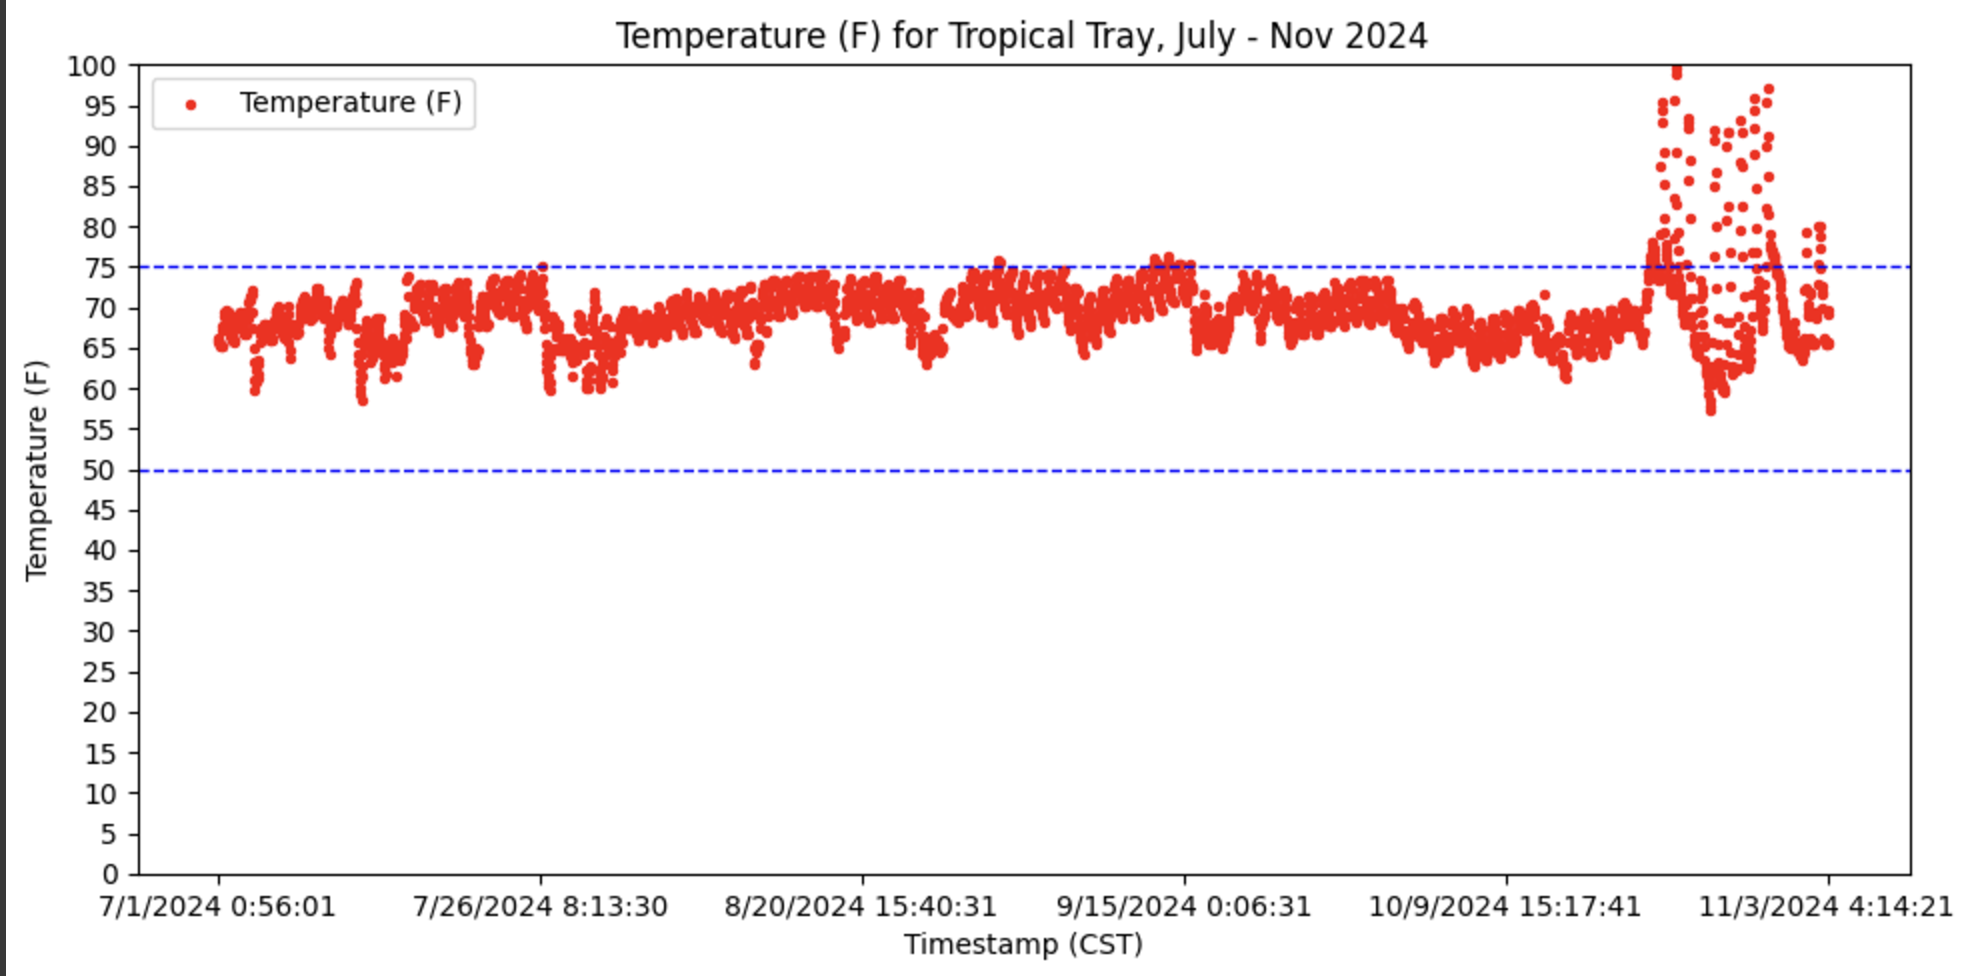

# Periodograms - Let's Check for Trends

We can use a periodogram to determine if there's any trends to be sure. Real data is often noisy. A periodogram helps determine if there's any notable frequencies or harmonics within the data by plotting the data within the frequency domain rather than a time-series domain.

Frequencies tells us whether there's any cycles in the data, and specifically how fast those cycles are; that is, repeated patterns. We can use oscillations to our advantage to figure out how quickly water runs out in the future.

In a periodogram, notable frequencies appear as spikes above the noise floor. We are looking for these notable spikes if there's anything we can use to our advantage for future predictions!

Run the following script that imports the scipy module, another datascience module, that helps us run a periodogram on the data.

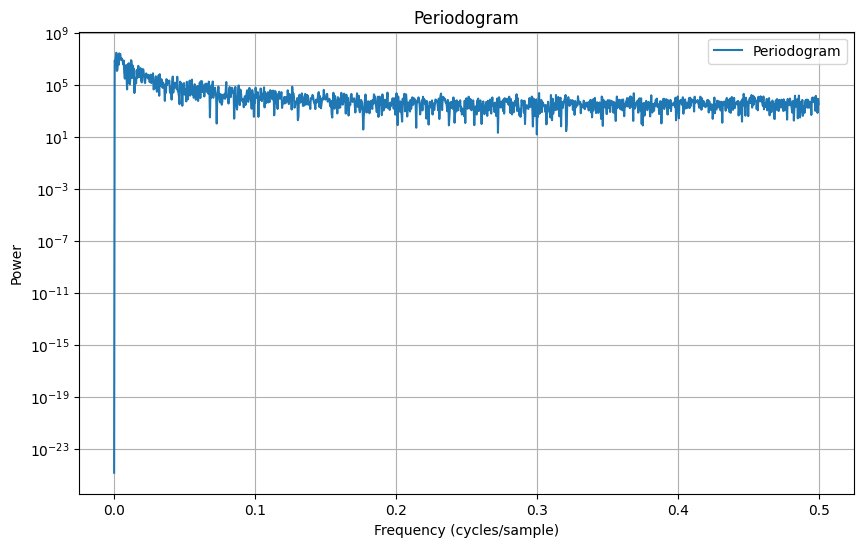

In [ ]:
from scipy.signal import periodogram, detrend

#Keep the first 2,500 ordered pairs
filtered_pairs = xy[:2500]

#all of the rows and just the y column
filtered_y = filtered_pairs[:, 1]

# Detrend the data (removes linear trends)
detrended_y = detrend(filtered_y)

#Compute the periodogram
frequencies, power = periodogram(detrended_y)

# Plot the periodogram
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, power, label='Periodogram')
plt.xlabel('Frequency (cycles/sample)')
plt.ylabel('Power')
plt.title('Periodogram')
plt.legend()
plt.grid(True)
plt.show()

Looking at the periodogram, our suspicions are indeed true. Notice the main frequency is nearly 0, and isn't very well differentiated from the noise floor. The smaller the frequency, the less likely there is any notable periodic trends because the period of our wave is almost infinity (frequency = 1 / period). By the looks of it, it's likely the data isn't periodic and we won't be able to use it in its current state to make predictions.

# What's Next?

I'll be rerunning data collection, but this time I'll have an irrigation device turn on whenever the tray is near empty. We'll then examine how long it takes for our water to run out, and how we can use this data for an alert system.

I'll walk you through how to put a simple one together further down the road!

However, there is much more to explore with the current dataset, that I'll leave it over to you.

A couple of questions for those interested in exploring:

1. What likely happened passed day 104 (2,500 hrs) to cause noisy data?
2. What happens if you plot and run a periodogram analysis on the temperature and humidity data. What can we use this data for?
3. Anything notable with the air pressure data, what might explain the trends or lack thereof there?
4. Be creative: what other analytical tools are out there that we can use on this dataset?